In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')

**Uniform random feature experiments**

In [2]:
save_folder = f'../data/uniform-RF'
D, D_r = 3, 300
w, b = 0.4, 4
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 20000
n_models = percents * n_repeats
row_selection = 'uniform'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test[:1], dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
batch.run_uniform(w, b, save_data=True)
bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
# bsa.compute_train_loss(train)
# bsa.compute_test_loss_single(test)

Running experiments ...
Working on batch 0 ...
Documenting results ...
Time taken for batch of experiments = 11.57s
Working on batch 1 ...


KeyboardInterrupt: 

**Histogram of phi**

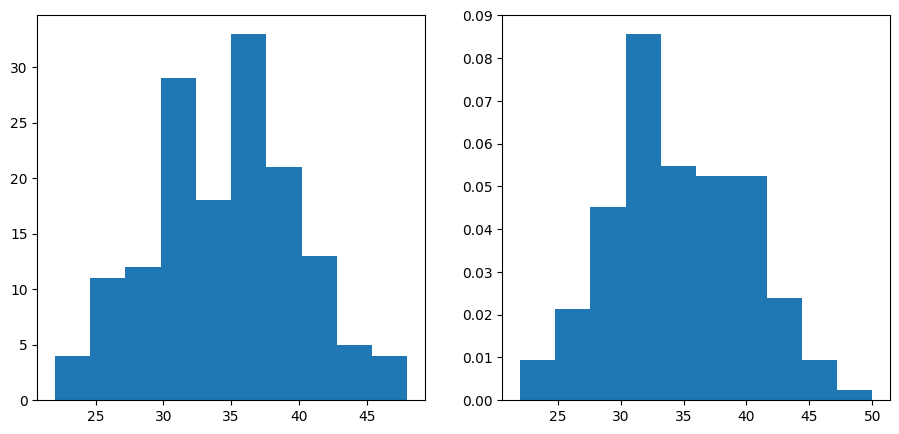

In [112]:
n = 1000
data = bsa.get_data()
phi_b, phi_g = [], []
threshold = 0.998
index_b, nature_b = data[data['tau_f_se'] < 0.5]['l'].to_numpy().astype(int), 'bad'
test_path = test[0,:, :1]
tau_f_b = []
tau_f_g = []

for i in index_b[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_b.append((f < 0.9).sum())
    tau_f_b.append(data['tau_f_se'][i])

index_g, nature_g = data[data['tau_f_se'] > 6]['l'].to_numpy().astype(int), 'good' 
for i in index_g[:150]:
    model = bsa.get_model(i)
    f = np.abs(np.tanh(model.W_in @ test_path + model.b_in[:, np.newaxis]))
    phi_g.append((f < 0.9).sum())
    tau_f_g.append(data['tau_f_se'][i])

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax.hist(phi_g, density=0)
# ax.hist(phi_b, density=0, alpha=0.7)
# ax.set_xlim(-0.1, 0)
# ax1.set_xlim(-0.1, 0)
ax.hist(phi_b)
ax1.hist(phi_g, density=1)
plt.show()

In [2]:
save_folder = '../data/bad-features-grid-1'
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
w_max, b_max = 0.4, 4.0
sqrt_n_models = 30
n_repeats = 100

L63_data_folder = '../data/L63-trajectories'
train = np.load('{}/train.npy'.format(L63_data_folder))
validation = np.load('{}/validation.npy'.format(L63_data_folder))#[:, :800]
batch = sr.BatchUniform_SMLR(save_folder, D, D_r, w_max, b_max, sqrt_n_models, beta, error_threshold, dt, Lyapunov_time)
# batch.run(train[:, :20000], n_repeats)

In [4]:
bsa = sr.BatchRunAnalyzer_SMLR(save_folder)
# bsa.compute_error(validation, rmse_threshold=np.sqrt(0.05))
# bsa.count(validation[:5000], limits_in=[-0.1, 0.1], limits=[-0.5, 0.5], threshold=3.5)

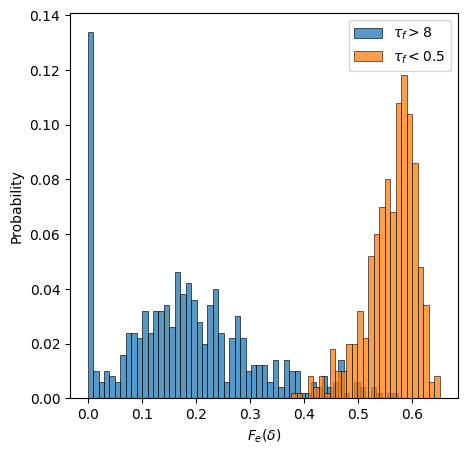

In [64]:
n, nbins, stat = 500, 100, 'probability'
data = bsa.get_data()
d_b = data[data['tau_f_se'] < 0.5]['avg_bad_features'].to_numpy()/D_r
index_b = np.random.choice(len(d_b), n, replace=False)
d_b = d_b[index_b]
dx_b = d_b.max() - d_b.min()


d_g = data[data['tau_f_se'] > 8.0]['avg_bad_features'].to_numpy()/D_r
index_g = np.random.choice(len(d_g), n, replace=False)
d_g = d_g[index_g]
dx_g = d_g.max() - d_g.min()



fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sns.histplot(d_g, ax=ax, stat=stat, label=r'$\tau_f>8$', bins=int(dx_g*nbins))
sns.histplot(d_b, ax=ax, stat=stat, label=r'$\tau_f<0.5$', bins=int(dx_b*nbins))
ax.legend()
ax.set_xlabel(r'$F_e(\delta)$')
plt.savefig('../data/plots/bad-fetaures-histogram.png', dpi=300)
plt.show()

Time taken by get_mean_std is 0.2718 seconds


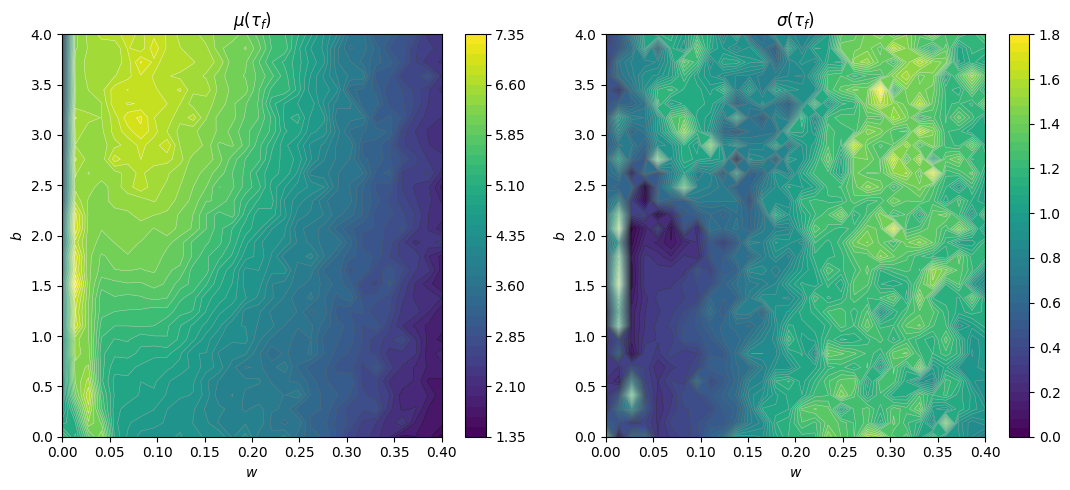

In [5]:
w = np.linspace(0., 0.4, num=30)
b = np.linspace(0., 4.0, num=30)
w, b = np.meshgrid(w, b)
tau, std = bsa.get_mean_std('tau_f_se')
fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
n = 50
im = ax.contourf(w, b, tau.T, n, cmap='viridis')
im_ = ax.contour(w, b, tau.T, n, cmap='Greys_r', linewidths=0.3)
fig.colorbar(im, ax=ax)
im1 = ax1.contourf(w, b, std.T, n, cmap='viridis')
im1_ = ax1.contour(w, b, std.T, n, cmap='Greys_r', linewidths=0.3)
fig.colorbar(im1, ax=ax1)
ax.set_xlabel(r'$w$')
ax.set_ylabel(r'$b$')
ax.set_title(r'$\mu(\tau_f)$')
ax1.set_xlabel(r'$w$')
ax1.set_ylabel(r'$b$')
ax1.set_title(r'$\sigma(\tau_f)$')
plt.tight_layout()
plt.savefig('../data/plots/tau_f-heat.png', dpi=300)

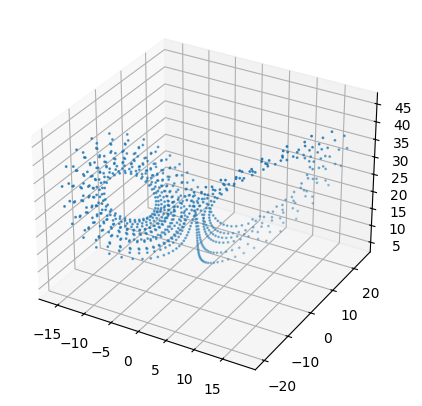

In [58]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(validation[0, :800], validation[1, :800], validation[2, :800], s=1)

In [59]:
5000/800

6.25